<a href="https://colab.research.google.com/github/rahiakela/deep-learning-research-and-practice/blob/main/inside-deep-learing/03-convolutional-neural-networks/01_convolutional_neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Convolutional neural networks

The success of convolutions comes from their ability to learn spatial patterns, which
has made them the default method to use for any data resembling an image.

Specifically, deep learning has been most successful at imposing
structural priors. By how we design the network, we impart some knowledge about the
intrinsic nature or structure of the data. 

The most common types of structure encoded
into neural networks are spatial correlation (i.e., images) and sequential
relationships (e.g., weather changes from one day to the next).

Images, however, are structured. There is an order to the pixels. If you shuffled the
pixels around, you would fundamentally change the meaning of a picture.

<img src='https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/inside-deep-learing/03-convolutional-neural-networks/images/cnn1.png?raw=1' width='600'/>

##Setup

In [ ]:
!wget https://github.com/EdwardRaff/Inside-Deep-Learning/raw/main/idlmam.py

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision 
from torchvision import transforms

from torch.utils.data import Dataset, DataLoader

from tqdm.autonotebook import tqdm

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from sklearn.metrics import accuracy_score
from sklearn.datasets import make_moons

from scipy.signal import convolve

import time

from idlmam import train_simple_network, set_seed

In [3]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

torch.backends.cudnn.deterministic=True
set_seed(1)

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

##Preparing dataset

Here, we will start exploring the ubiquitous MNIST dataset. 

It’s a collection of black-and-white images of the digits 0
through 9; each is 28 pixels wide and 28 pixels tall.

In [ ]:
mnist_data_train = torchvision.datasets.MNIST("./data", train=True, download=True)
mnist_data_test = torchvision.datasets.MNIST("./data", train=False, download=True)

x_example, y_example = mnist_data_train[0]

In [7]:
type(x_example), type(y_example)

(PIL.Image.Image, int)

Now you will notice that the type of the data returned is not a tensor.

We need to use a transform to convert the images to tensors.

In [6]:
# simply specify the ToTensor transform, which converts image into a tensor
mnist_data_train = torchvision.datasets.MNIST("./data", train=True, download=True, transform=transforms.ToTensor())
mnist_data_test = torchvision.datasets.MNIST("./data", train=False, download=True, transform=transforms.ToTensor())

x_example, y_example = mnist_data_train[0]
type(x_example), type(y_example)

(torch.Tensor, int)

In [9]:
print(x_example.shape)

torch.Size([1, 28, 28])


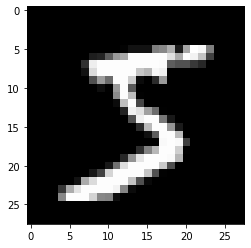

In [10]:
# visualize a tensor representation of an image
imshow(x_example[0, :], cmap="gray")

Let’s do a color version. If we stack three copies of the same digit on top of each other, we will have a tensor of shape `(3, 28, 28)`. 

Because the structure of the tensor has meaning,
this instantaneously makes it a color image by virtue of having three channels.

In [11]:
x_as_color = torch.stack([x_example[0, :], x_example[0, :], x_example[0, :]], dim=0)
print(x_as_color.shape)

torch.Size([3, 28, 28])


Now let’s visualize the color version.

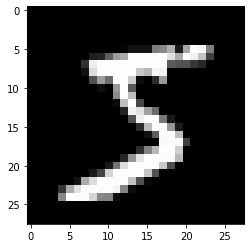

In [12]:
# need to permute the dimensions when using imshow
imshow(x_as_color.permute(1, 2, 0))

Why is this color image still black and white? 

Because the original image was black and
white. We have the same value copied in the red, green, and blue channels, which is
how you represent a black-and-white image in color. 

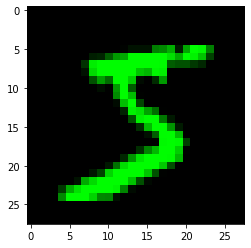

In [13]:
x_as_color = torch.stack([x_example[0, :], x_example[0, :], x_example[0, :]])

# If we zero out the red and blue channels, we get a green number
x_as_color[0, :] = 0  # No Red. We’re leaving Green alone.
x_as_color[2, :] = 0  # No Blue

imshow(x_as_color.permute(1, 2, 0))

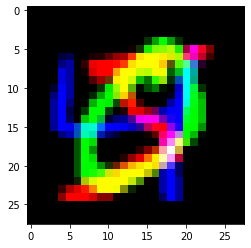

In [14]:
# let’s stack three different images together into one color image
x1, x2, x3 = mnist_data_train[0], mnist_data_train[1], mnist_data_train[2]  # Grabs 3 images
x1, x2, x3 = x1[0], x2[0], x3[0]   # drop the label

x_as_color = torch.stack([x1[0, :], x2[0, :], x3[0, :]], dim=0)
imshow(x_as_color.permute(1, 2, 0))

The order of the data has
meaning, and we can’t arbitrarily reorder things without potentially destroying the
structure and thus the data.

Let’s look at this more explicitly. 

What happens if we shuffle the data within a channel?
Does it have the same important structured meaning? 

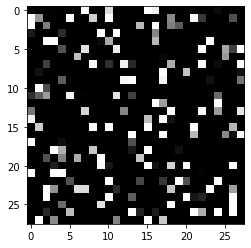

In [15]:
# Let’s look at the digit 5 one last time but randomly shuffle the values in the tensor
rand_order = torch.randperm(x_example.shape[1] * x_example.shape[2])
x_shuffled = x_example.view(-1)[rand_order].view(x_example.shape)

imshow(x_shuffled[0, :], cmap="gray")

As you can see, this has completely changed the meaning of the image. 
Instead of being a 5, it’s . . . nothing, really.

**The locations of a value and its nearby values are intrinsically part
of that value’s meaning. The value of one pixel cannot be separated from its neighbors. This is the structural spatial prior we try to capture.**

##1D convolutions

To understand how a convolution works, let’s talk about a one-dimensional CNN first.

<img src='https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/inside-deep-learing/03-convolutional-neural-networks/images/cnn2.png?raw=1' width='600'/>

For each output, you can see arrows
coming in for the spatially relevant inputs for that output.

Notice it is always the same three values
from the filter, applied to every position in the input.

In [16]:
filter = [1, 0, -1]
input = [1, 0, 2, -1, 1, 2]
output = []

# Slides the filter over the input
for i in range(len(input) - len(filter)):
  result = 0
  # Applies the filter at this location
  for j in range(len(filter)):
    result += input[i + j] * filter[j]
  output.append(result)
print(output)

[-1, 1, 1]


In effect, we are sliding the filter across every location in the input, computing a value at
each location, and storing it in the output. That’s what a convolution is. 

The size of the output shrinks because we run out of values at the edges of the input.

##2D convolutions

As we increase the number of dimensions $r$ in our tensor, the idea of convolutions and
how they work stays the same: we slide a filter around the input, multiply the values in
the filter with each area of the image, and then take the sum.

<img src='https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/inside-deep-learing/03-convolutional-neural-networks/images/cnn3.png?raw=1' width='600'/>

Again, the 2D output results from multiplying the filter values (pairwise) at each location
and summing them all.

In [17]:
filter = [
  [0, 1, 0],
  [0, 1, 0],
  [0, 1, 0]        
]
input = [
  [0, 0, 1, 1, 0, 0],
  [0, 1, 0, 1, 0, 0],
  [0, 0, 0, 1, 0, 0],
  [0, 0, 0, 1, 0, 0],
  [0, 0, 0, 1, 1, 0],
  [0, 1, 1, 1, 1, 1]      
]

height, width = len(input), len(input[0])
output = []

# Slides the filter over the rows
for i in range(height - len(filter)):
  row_out = []
  # Slides the filter over the columns
  for j in range(width - len(filter)):
    result = 0
    # Applies the filter at this location
    for k_i in range(len(filter)):
      for k_j in range(len(filter)):
        result += input[i + k_i][j + k_j] * filter[k_i][k_j]
    row_out.append(result)
  output.append(row_out)

print(output)

[[1, 1, 3], [1, 0, 3], [0, 0, 3]]


##Image processing

Let’s again look at a specific image of the digit 4 from MNIST.

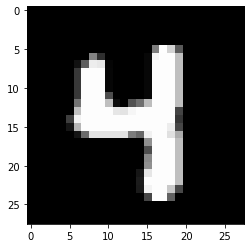

In [12]:
img_index = 58
img = mnist_data_train[img_index][0][0, :]
plt.imshow(img, vmin=0, vmax=1, cmap="gray")

One common computer vision operation is to blur an image. Blurring involves taking
a local average pixel value and replacing every pixel with the average of its neighbors.

This can be useful to wash out small noisy artifacts or soften a sharp edge.

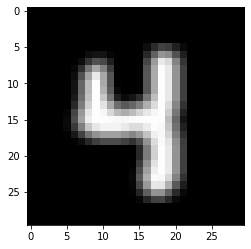

In [19]:
blur_filter = np.asarray([
    [1, 1, 1],
    [1, 1, 1],
    [1, 1, 1]                    
]) / 9.0

blurry_img = convolve(img, blur_filter)
plt.imshow(blurry_img, vmin=0, vmax=1, cmap="gray")
plt.show()

An especially common application of convolutions is to perform edge detection.

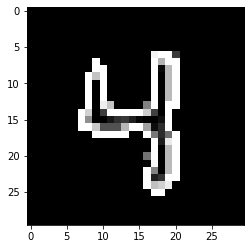

In [20]:
# find edges by focusing on the difference between a pixel and its neighbors
edge_filter = np.asarray([
   [-1, -1, -1], 
   [-1, 8, -1],
   [-1, -1, -1],                      
])

edge_img = convolve(img, edge_filter)
plt.imshow(edge_img, vmin=0, vmax=1, cmap="gray")
plt.show()

If we constrain ourselves to a `3 x 3` kernel, it is easiest to find horizontal or vertical edges. 

Let’s create one for horizontal edges by making the kernel values change signs across the horizontal of the filter.

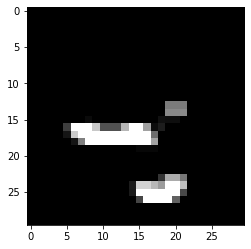

In [21]:
# look for only horizontal edges
h_edge_filter = np.asarray([
   [-1, -1, -1], 
   [0, 0, 0],
   [1, 1, 1],                      
])

h_edge_img = convolve(img, h_edge_filter)
plt.imshow(h_edge_img, vmin=0, vmax=1, cmap="gray")
plt.show()

Let’s create one for vertical edges by making the kernel values change signs across the vertical of the filter.

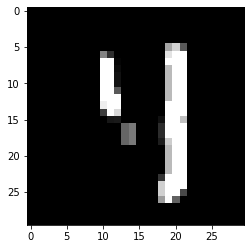

In [22]:
# look for only vertical edges
v_edge_filter = np.asarray([
   [-1, 0, 1], 
   [-1, 0, 1],
   [-1, 0, 1],                      
])

v_edge_img = convolve(img, v_edge_filter)
plt.imshow(v_edge_img, vmin=0, vmax=1, cmap="gray")
plt.show()

##First naive CNN

Let's create a DataLoader for the training and testing sets.

In [8]:
batch_size = 32

mnist_train_loader = DataLoader(mnist_data_train, batch_size=batch_size, shuffle=True)
mnist_test_loader = DataLoader(mnist_data_test, batch_size=batch_size, shuffle=False)

How many values are in the input? 

We use this to help determine the size of subsequent layers.

In [9]:
# 28 * 28 images
D = 28 * 28

# How many channels are in the input?
C = 1

# How many classes are there?
classes = 10

# How many filters should we use
filters = 16

# how large should our filters be?
K = 3

For comparison, let’s define a linear model of similar complexity.

In [25]:
model_linear = nn.Sequential(
  nn.Flatten(),       # (B, C, W, H) -> (B, C*W*H) = (B,D)
  nn.Linear(D, 256),
  nn.Tanh(),
  nn.Linear(256, classes)
)

And now, let's define a simple convolutional network.

In [26]:
model_cnn = nn.Sequential(
  nn.Conv2d(C, filters, K, padding=K // 2),  # Conv2d(# of input channels, #filters/output-channels, #filter-size)
  nn.Tanh(),
  nn.Flatten(),                              # Convert from (B, C, W, H) ->(B, D). This way we can use a Linear layer after
  nn.Linear(filters * D, classes)
)

Does a CNN perform better than a fully connected model? 

Let’s find out.

In [ ]:
loss_func = nn.CrossEntropyLoss()
cnn_results = train_simple_network(model_cnn, 
                                   loss_func,
                                   mnist_train_loader, 
                                   test_loader=mnist_test_loader, 
                                   score_funcs={"Accuracy": accuracy_score},
                                   device=device,
                                   epochs=20)

In [ ]:
fc_results = train_simple_network(model_linear, 
                                  loss_func,
                                  mnist_train_loader, 
                                  test_loader=mnist_test_loader, 
                                  score_funcs={"Accuracy": accuracy_score},
                                  device=device,
                                  epochs=20)

Let's plot the test accuracy.

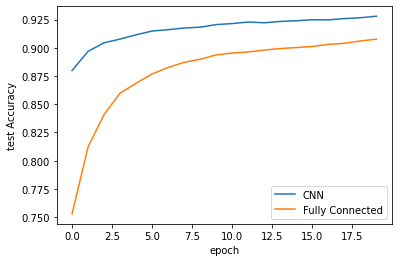

In [29]:
sns.lineplot(x="epoch", y="test Accuracy", data=cnn_results, label="CNN")
sns.lineplot(x="epoch", y="test Accuracy", data=fc_results, label="Fully Connected")

One epoch of training our CNN has better accuracy than our fully connected network ever achieves.

Because we have given the network information about the problem (convolutions) via the structure of the domain (data consists of
images). 

This does not mean CNNs are always better: if the assumptions for a CNN are
not true or accurate, they will not perform well. 

Remember that convolutions impart the prior belief that things located near each other are related, but things far from each other are not related.



##Mitigate object movement using pooling

Let’s quickly grab an image from the MNIST dataset and create two altered versions by moving the content ever so slightly up or down by one pixel:

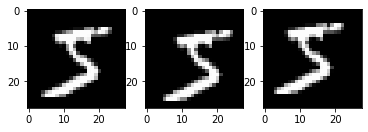

In [30]:
img_index = 0
img, correct_class = mnist_data_train[img_index]
img = img[0, :]

# move to the lower right, then upper left
img_lr = np.roll(np.roll(img, 1, axis=1), 1, axis=0)
img_ul = np.roll(np.roll(img, -1, axis=1), -1, axis=0)

#plot the images
f, axarr = plt.subplots(1,3)
axarr[0].imshow(img, cmap='gray')
axarr[1].imshow(img_lr, cmap='gray')
axarr[2].imshow(img_ul, cmap='gray')
plt.show()

It does not matter that we shifted the content up or down, left or right, by just a few pixels. 

But our model does not know this. 

If we classify different versions of image, there is a good chance we will get it wrong.

Let’s quickly put this model into `eval()` mode and write a function to get the predictions for a single image.

In [31]:
# eval mode since we are not training
model = model_cnn.cpu().eval()

def predict(model, img):
  # Always turn off gradients when evaluating
  with torch.no_grad():
    # Whats the width/height of the image
    w, h = img.shape
    if not isinstance(img, torch.Tensor):
      img = torch.tensor(img)
    x = img.reshape(1, -1, w, h)     # reshape it as (B, C, W, H)
    logits = model(x)                # Get the logits
    y_hat = F.softmax(logits, dim=1) #Turn into probabilities
    return y_hat.numpy().flatten()   # convert prediction to numpy array

This is a simple way to apply a model to single images.

In [32]:
img_pred = predict(model, img)
img_lr_pred = predict(model, img_lr)
img_ul_pred = predict(model, img_ul)

print("Original Img Class {} Prob:    ".format(correct_class), img_pred[correct_class])
print("Lower Right Img Class {} Prob: ".format(correct_class), img_lr_pred[correct_class])
print("Uper Left Img Class {} Prob:   ".format(correct_class), img_ul_pred[correct_class])

Original Img Class 5 Prob:     0.83023196
Lower Right Img Class 5 Prob:  0.514054
Uper Left Img Class 5 Prob:    0.37034678


Clearly, we want all three examples to receive the same classification. They are essentially
the same image, yet the outputs swing from a reasonably confident and correct 78.2%
down to an erroneous 31.5%. 

The problem is that a small shift or translation causes the
predictions to change significantly.

What we desire is a property called translation invariance. Being invariant to property $X$ means our output does not change based on changes to $X$. 

We do not want translations(shifting up/down) to change our decisions—we want to be translation invariant.



##CNNs with max pooling

Pooling can enable us to obtain partial translation invariance.

The intuition behind pooling is that it gives us more robustness to slight changes in values.

Every time pooling is applied, we shrink the width (and
height, if 2D) by a factor of $K$. So n rounds of pooling means shrinking by a factor of $K^n$, which will make the image very small very quickly. 

For MNIST, we only have 28
pixels of width, so we can do at most four rounds of pooling with a size of $K = 2$. That’s because five rounds would give us 28/25 = 28/32, which is less than a pixel of output.

Four rounds of pooling means shrinking the image
to just 28/24 = 28/16 = 1:75 pixels tall. If you could not guess what digit was being
represented with 1.75 pixels, your CNN probably couldn’t either. 

Visually shrinking
your data is a good way to estimate the maximum amount of pooling you should apply to most problems.

Visually shrinking your data is a good way to estimate the maximum amount of pooling you should apply to most problems.

Let’s quickly try this on our MNIST data.

In [21]:
K = 3

model_cnn_pool = nn.Sequential(
  nn.Conv2d(C, filters, K, padding=K // 2), 
  nn.Tanh(),
  nn.Conv2d(filters, filters, K, padding=K // 2), 
  nn.Tanh(),
  nn.Conv2d(filters, filters, K, padding=K // 2), 
  nn.Tanh(),
  nn.MaxPool2d(2),
  nn.Conv2d(filters, 2 * filters, K, padding=K // 2),
  nn.Tanh(),
  nn.Conv2d(2 * filters, 2 * filters, K, padding=K // 2), 
  nn.Tanh(),
  nn.Conv2d(2 * filters, 2 * filters, K, padding=K // 2), 
  nn.Tanh(),
  nn.MaxPool2d(2),

  nn.Flatten(),                              # Convert from (B, C, W, H) ->(B, D). This way we can use a Linear layer after
  # Because pooling a 2x2 grid down to one value means going from four values to one, and we do this twice
  nn.Linear(2 * filters * D // (4**2), classes)
)

In [ ]:
cnn_results_pool = train_simple_network(model_cnn_pool, 
                                        loss_func,
                                        mnist_train_loader, 
                                        test_loader=mnist_test_loader, 
                                        score_funcs={"Accuracy": accuracy_score},
                                        device=device,
                                        epochs=20)

Now, if we run the same shifted test image through our model, we should see different results. 

Max pooling is not a perfect solution to the translation problem, so the scores for
each shifted version of the image still change. But they don’t change as much.

In [35]:
model = model_cnn_pool.cpu().eval()

img_pred = predict(model, img)
img_lr_pred = predict(model, img_lr)
img_ul_pred = predict(model, img_ul)

print("Original Img Class {} Prob:    ".format(correct_class), img_pred[correct_class])
print("Lower Right Img Class {} Prob: ".format(correct_class), img_lr_pred[correct_class])
print("Uper Left Img Class {} Prob:   ".format(correct_class), img_ul_pred[correct_class])

Original Img Class 5 Prob:     0.75754017
Lower Right Img Class 5 Prob:  0.79272246
Uper Left Img Class 5 Prob:    0.8065965


Adding more layers causes our network to take much longer
to converge, but once it does, it can eke out a little better accuracy:

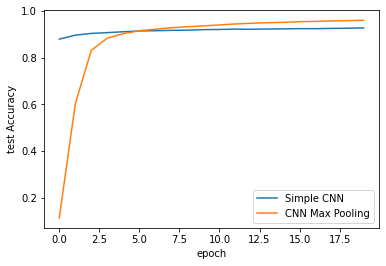

In [36]:
sns.lineplot(x="epoch", y="test Accuracy", data=cnn_results, label="Simple CNN")
sns.lineplot(x="epoch", y="test Accuracy", data=cnn_results_pool, label="CNN Max Pooling")

##Data augmentation

In general, neural networks are data-hungry, meaning they learn best when you have a
huge amount of diverse data. Since it takes time to obtain data, we will instead augment
our real data by creating new, fake data based on the real data.

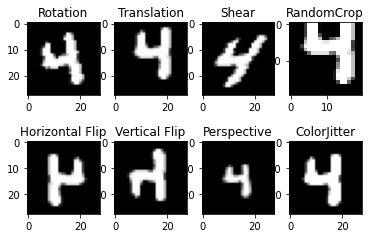

In [13]:
# Several built-in transformations, given some agressive values to make their impact more obvious
sample_transforms = {
  "Rotation": transforms.RandomAffine(degrees=45),
  "Translation": transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
  "Shear": transforms.RandomAffine(degrees=0, shear=45),
  "RandomCrop": transforms.RandomCrop((20, 20)),
  "Horizontal Flip": transforms.RandomHorizontalFlip(p=1.0),
  "Vertical Flip": transforms.RandomVerticalFlip(p=1.0),
  "Perspective": transforms.RandomPerspective(p=1.0),
  "ColorJitter": transforms.ColorJitter(brightness=0.9, contrast=0.9)
}

# Convert the Tensor image back to a PIL image using a transform
pil_img = transforms.ToPILImage()(img)

# Plot a randomy application of each transform
fig, ax = plt.subplots(2, 4)
for count, (name, t) in enumerate(sample_transforms.items()):
  row = count % 4
  col = count // 4
  ax[col, row].imshow(t(pil_img), cmap="gray")
  ax[col, row].set_title(name)
plt.show()

Not every transform should always be used. Make sure that your transforms preserve
the essence or meaning of your data.

But once you select a set of transforms you are comfortable with, this is a simple and
powerful approach to improve your model’s accuracy.

Following is a short example of using
the Compose transform to create a sequence of transforms in a larger pipeline, which
we can apply to augment training data on the fly.

In [ ]:
train_transform = transforms.Compose([
  transforms.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.98, 1.02)),
  transforms.ToTensor()                                     
])

test_transform = transforms.ToTensor() 

mnist_train_transformed = torchvision.datasets.MNIST("./data", train=True, transform=train_transform)
mnist_test_transformed = torchvision.datasets.MNIST("./data", train=False, transform=test_transform)

mnist_train_loader_transformed = DataLoader(mnist_train_transformed, shuffle=True, batch_size=batch_size, num_workers=5)
mnist_test_loader_transformed = DataLoader(mnist_test_transformed, batch_size=batch_size, num_workers=5)

The data augmentation happens automatically by defining these new
data loaders. 

A simple ToTensor transform is all we use for the test set because we want
the test set to be deterministic —that means if we run the same model five times on the test set, we get the same answer five times:

In [23]:
K = 3

model_cnn_pool = nn.Sequential(
  nn.Conv2d(C, filters, K, padding=K // 2), 
  nn.Tanh(),
  nn.Conv2d(filters, filters, K, padding=K // 2), 
  nn.Tanh(),
  nn.Conv2d(filters, filters, K, padding=K // 2), 
  nn.Tanh(),
  nn.MaxPool2d(2),
  nn.Conv2d(filters, 2 * filters, K, padding=K // 2),
  nn.Tanh(),
  nn.Conv2d(2 * filters, 2 * filters, K, padding=K // 2), 
  nn.Tanh(),
  nn.Conv2d(2 * filters, 2 * filters, K, padding=K // 2), 
  nn.Tanh(),
  nn.MaxPool2d(2),

  nn.Flatten(),                              # Convert from (B, C, W, H) ->(B, D). This way we can use a Linear layer after
  # Because pooling a 2x2 grid down to one value means going from four values to one, and we do this twice
  nn.Linear(2 * filters * D // (4**2), classes)
)

In [ ]:
cnn_results_pool_augmented = train_simple_network(model_cnn_pool,
                                                  loss_func,
                                                  mnist_train_loader_transformed, 
                                                  test_loader=mnist_test_loader_transformed, 
                                                  score_funcs={"Accuracy": accuracy_score},
                                                  device=device,
                                                  epochs=20)

We can now plot the result showing the difference in validation accuracy.

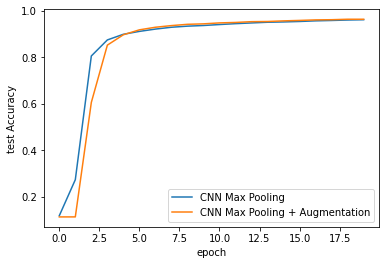

In [25]:
sns.lineplot(x="epoch", y="test Accuracy", data=cnn_results_pool, label="CNN Max Pooling")
sns.lineplot(x="epoch", y="test Accuracy", data=cnn_results_pool_augmented, label="CNN Max Pooling + Augmentation")

Designing good data augmentation pipelines is the feature engineering counterpart
to deep learning. If you do it well, it can have a massive impact on your results and
be the difference between success and failure.

Data augmentation also increases the value of
training for more epochs. Without augmentation, each epoch revisits the exact same
data; with augmentation, your model sees a different variant of the data that helps it
better generalize to new data.

